In [39]:
import warnings
warnings.filterwarnings('ignore')

import scipy
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [8]:
X, y = make_blobs(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

logreg = LogisticRegression().fit(x_train, y_train)

print('Test set score : {}'.format(logreg.score(x_test, y_test)))

Test set score : 0.88


### 교차 검증 
#### k-fold 교차검증

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print('Cross validation score : {}'.format(scores))

Cross validation score : [0.96078431 0.92156863 0.95833333]


In [10]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)#cv에 숫자로 넣는건 평소에 알던 방식이 아님.
print('Cross validation score : {}'.format(scores))

Cross validation score : [1.         0.96666667 0.93333333 0.9        1.        ]


In [14]:
print('Mean Cross validation score : {:.2f}'.format(scipy.mean(scores)))

Mean Cross validation score : 0.96


#### 교차 검증 상세 옵션
sklearn cross_val_score 함수에 cv 파라미터로 교차 검증 분할기를 전달하면, 세밀하게 제어 가능. (내가 기존에 알고 있던 방식)

In [15]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [16]:
print('Cross validation score : {}'.format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross validation score : [1.         0.93333333 0.43333333 0.96666667 0.43333333]


#### 기본 kfold 분할이 좋지 않은 경우 살펴보기
iris data의 경우 동일한 비율로 3-fold로 분할하면, 각 폴드가 3개의 클래스 별로 대응하므로 아무것도 학습할 수 없음.(데이터 순서에 영향을 받는다.)

In [17]:
kfold = KFold(n_splits=3)
print('Cross validation score : {}'.format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross validation score : [0. 0. 0.]


shuffle 옵션으로 데이터셋을 섞으면 이런 문제를 해결할 수 있음.

In [18]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print('Cross validation score : {}'.format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross validation score : [0.9  0.96 0.96]


#### 또 다른 교차 검증 방법 LOOCV
Leave One out cross validation, 폴드에 하나만 들어 있는 kfold와 동일. 데이터셋이 클 경우에는 오래걸리지만, 작은 데이터셋에서는 좋은 결과를 만들어낼 수 있음.

In [20]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print('# of split for Cross validation : ', len(scores))
print('Mean Accuracy : {:.2f}'.format(scores.mean()))

# of split for Cross validation :  150
Mean Accuracy : 0.95


#### 임의 분할 교차 검증
train, test 셋의 비율 대로 데이터를 분할한다, 두 비율의 합이 1이 아닌 경우에는 남은 비율은 폴드로 선택하지 않는다.<br> ex) train=0.5, test=0.2인 경우 0.3 비율의 폴드는 선택하지 않음.

In [21]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print('Cross validation socre : {}'.format(scores))

Cross validation socre : [0.93333333 0.94666667 0.92       0.93333333 0.97333333 0.93333333
 0.92       0.98666667 0.88       0.96      ]


#### 그룹별 교차 검증
'기존 데이터와 새로 수집된 데이터' 라는 그룹으로 나뉘어 있는 경우 모델을 기존 데이터로 학습하고 새로 수집된 데이터를 예측하여 모델을 평가한다고 해보자.<br>
이런 경우에는 단순히 split할 경우에는 기존 데이터과 새로 수집된 데이터가 섞여들어갈 수 있다. 이러한 경우 그룹별로 split하는 GroupKfold를 살펴보자.

In [22]:
from sklearn.model_selection import GroupKFold

X, y = make_blobs(n_samples=12, random_state=0)

groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print('Cross validation score : {}'.format(scores))

Cross validation score : [0.75       0.8        0.66666667]


### 그리드 서치
모델에 들어갈 매개변수 선택하기. 그리드라는 말처럼 각 매개변수마다 여러 세팅 값들을 지정해두고 해당 세팅 값을 모두 테스트하여 가장 좋은 성능의 모델을 찾는 것.

In [24]:
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print('Size of Train set : {}, Size of Test set : {}'.format(x_train.shape[0], x_test.shape[0]))

Size of Train set : 112, Size of Test set : 38


In [26]:
best_score=0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(x_train, y_train)
        score = svm.score(x_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
print('best score : {:.2f}'.format(best_score))
print('best parameter : {}'.format(best_parameters))

best score : 0.97
best parameter : {'C': 100, 'gamma': 0.001}


#### 교차 검증을 사용한 그리드 서치

In [29]:
x_trainval, x_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        
        scores = cross_val_score(svm, x_trainval, y_trainval, cv=5)
        
        score = scipy.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
svm = SVC(**best_parameters)
svm.fit(x_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
iris.data, iris.target, random_state=0)

In [32]:
grid_search.fit(x_train, y_train)

print('Test set Accuracy : {:.2f}'.format(grid_search.score(x_test, y_test)))

Test set Accuracy : 0.97


In [33]:
print('Optimal Prameters : {}'.format(grid_search.best_params_))
print('Best Cross validation score : {:.2f}'.format(grid_search.best_score_))

Optimal Prameters : {'C': 100, 'gamma': 0.01}
Best Cross validation score : 0.97


In [35]:
print('Best Performance Model : \n{}'.format(grid_search.best_estimator_))

Best Performance Model : 
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### 교차 검증 결과 분석
판다스 데이터 프레임을 사용해 깔끔하게 정리할 수 있다.

In [37]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000682,0.000161,0.000295,0.000026,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000585,0.000032,0.000275,0.000011,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000569,0.000013,0.000285,0.000022,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.000535,0.000012,0.000248,0.000004,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.000522,0.000017,0.000246,0.000008,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


In [42]:
scores = np.array(results.mean_test_score).reshape(6,6)

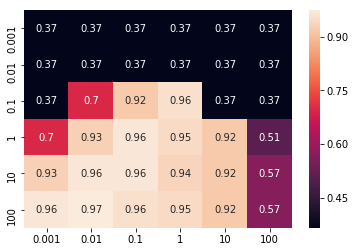

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(scores,
            xticklabels=param_grid['C'],
            yticklabels=param_grid['gamma'],
            annot=scores
           )

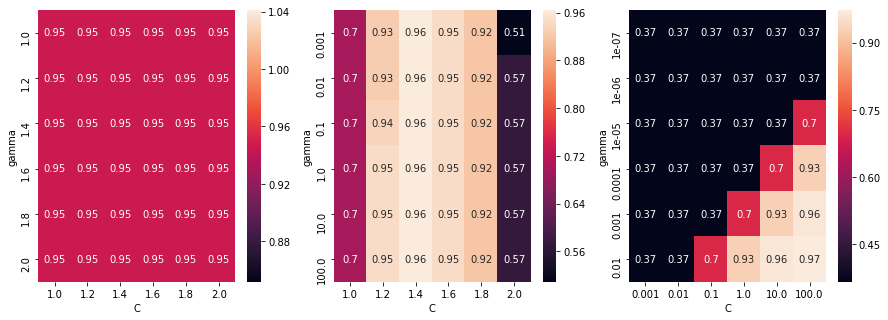

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
param_grid_linear = {'C':np.linspace(1, 2, 6),
                    'gamma':np.linspace(1, 2, 6)}

param_grid_one_log = {'C':np.linspace(1, 2, 6),
                     'gamma':np.logspace(-3, 2, 6)}

param_grid_range = {'C':np.logspace(-3, 2, 6),
                    'gamma':np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
    score_image = sns.heatmap(scores,
                             xticklabels=param_grid['C'],
                             yticklabels=param_grid['gamma'],
                             annot=scores, ax=ax)
    ax.set_xlabel('C')
    ax.set_ylabel('gamma')

#### 중첩 교차 검증.
cross_val_score로 trainval, test 분리하고 trainval 데이터로 GridSearchCV 함수 수행해서 가장 좋은 파라미터를 가진 모델로 검증.

In [69]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                        iris.data, iris.target, cv=5)
print('Cross validation score : {}'.format(scores))
print('Mean Cross validation score : {:.2f}'.format(scipy.mean(scores)))

Cross validation score : [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean Cross validation score : 0.98


CV랑 Grid Search는 멀티프로세싱이 가능함. n_jobs 매개변수에 -1을 주면 가능한 모든 코어를 사용함.

### 평가 지표와 측정
일반적으로 분류에서는 Accuracy를 사용하고, 회귀에서는 R<sup>2</sup>를 사용한다. 다른 평가 방법에 대해서도 알아보자.<br>
양성 테스트(암 진단)를 양성 클래스로하고, 음성 테스트를 음성 클래스라고 하자. 건강한 사람을(양성)으로 판단하는 것을 거짓 양성(false positive)라고 한다. 병이 있는데, 건강하다(음성)으로 판단하는 것을 거짓 음성(false negative)라 한다. 

* false positive : 실제로 오류가 존재하지않지만 오류라고 보고하는 경우를 말한다.
* true negative: 실제 오류가 존재하지 않고 보고도 안하는 경우를 말한다. 

* false negative : 실제로 오류가 존재하지만 오류가 없다고 보고하는 경우를 말한다.
* true positive : 실제 오류가 존재해서 보고하는 경우를 말한다.